# Privacy-Preserving Techniques for LLM Code Completion

This notebook measures and plots the privacy-utility trade-off for code completion using the HumanEval dataset.

## 1. Setup and Imports

In [1]:
import sys
sys.path.insert(0, '.')

from src.data import HumanEvalDataLoader
from src.obfuscation import LowObfuscator, HighObfuscator
from src.models import CodeCompletionModel
from src.evaluation import UtilityEvaluator, PrivacyEvaluator
from src.visualization import PrivacyUtilityPlotter

import numpy as np
import matplotlib.pyplot as plt

C:\Users\Andrea\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load HumanEval Dataset

Load the first 20 examples from the openai/openai_humaneval test split.

In [2]:
data_loader = HumanEvalDataLoader(num_examples=20)
data_loader.load_dataset()

prompts = data_loader.get_prompts()
canonical_solutions = data_loader.get_canonical_solutions()

print(f"Loaded {len(prompts)} examples")
print(f"\nExample prompt (first 300 chars):\n{prompts[0][:300]}...")

C:\Users\Andrea\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Andrea\.cache\huggingface\hub\datasets--openai--openai_humaneval. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating test split: 100%|██████████████████████████████████████████████████████████

Loaded 20 examples

Example prompt (first 300 chars):
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, ...


## 3. Define Obfuscation Functions

Two levels of obfuscation:
- **Low**: Rename variables to generic names (var1, var2, etc.)
- **High**: Replace all identifiers with placeholders and strip comments

In [3]:
low_obfuscator = LowObfuscator()
high_obfuscator = HighObfuscator()

low_obfuscated_prompts = [low_obfuscator.obfuscate(p) for p in prompts]
high_obfuscated_prompts = [high_obfuscator.obfuscate(p) for p in prompts]

print("Original prompt (first 200 chars):")
print(prompts[0][:200])
print("\nLow obfuscated (first 200 chars):")
print(low_obfuscated_prompts[0][:200])
print("\nHigh obfuscated (first 200 chars):")
print(high_obfuscated_prompts[0][:200])

Original prompt (first 200 chars):
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given thr

Low obfuscated (first 200 chars):
from typing import var1


def has_close_elements(var2: var1[float], var3: float) -> bool:
    """ Check if in given list of var2, are any two var2 closer to each other than
    given var3.
    >>> has

High obfuscated (first 200 chars):
from typing import List

def has_close_elements(numbers: List[float], threshold: float) -> bool:


## 4. Initialize Code Completion Model

Using Salesforce/codet5-small for code completion.

In [4]:
model = CodeCompletionModel(model_name="Salesforce/codet5-small", device="cpu")
model.load_model()
print("Model loaded successfully")

C:\Users\Andrea\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Andrea\.cache\huggingface\hub\models--Salesforce--codet5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Model loaded successfully


## 5. Generate Completions

Generate 60 completions total: 20 original, 20 low-obfuscated, 20 high-obfuscated.

In [5]:
print("Generating completions for original prompts...")
original_completions = model.generate_completions_batch(prompts)

print("Generating completions for low-obfuscated prompts...")
low_completions = model.generate_completions_batch(low_obfuscated_prompts)

print("Generating completions for high-obfuscated prompts...")
high_completions = model.generate_completions_batch(high_obfuscated_prompts)

print(f"\nGenerated {len(original_completions) + len(low_completions) + len(high_completions)} total completions")

Generating completions for original prompts...
Generating completions for low-obfuscated prompts...
Generating completions for high-obfuscated prompts...

Generated 60 total completions


## 6. Compute Utility Scores

Using ROUGE-L F1 score to compare completions to canonical solutions.

In [6]:
utility_evaluator = UtilityEvaluator()

original_utility = [utility_evaluator.get_utility_score(c, r) for c, r in zip(original_completions, canonical_solutions)]
low_utility = [utility_evaluator.get_utility_score(c, r) for c, r in zip(low_completions, canonical_solutions)]
high_utility = [utility_evaluator.get_utility_score(c, r) for c, r in zip(high_completions, canonical_solutions)]

print(f"Original - Mean Utility: {np.mean(original_utility):.4f}, Std: {np.std(original_utility):.4f}")
print(f"Low Obf  - Mean Utility: {np.mean(low_utility):.4f}, Std: {np.std(low_utility):.4f}")
print(f"High Obf - Mean Utility: {np.mean(high_utility):.4f}, Std: {np.std(high_utility):.4f}")

Original - Mean Utility: 0.0579, Std: 0.0746
Low Obf  - Mean Utility: 0.0057, Std: 0.0249
High Obf - Mean Utility: 0.1039, Std: 0.1265


## 7. Compute Privacy Scores

Using normalized Levenshtein distance between obfuscated and original prompts.

In [7]:
privacy_evaluator = PrivacyEvaluator()

original_privacy = [0.0] * len(prompts)
low_privacy = privacy_evaluator.compute_privacy_batch(prompts, low_obfuscated_prompts)
high_privacy = privacy_evaluator.compute_privacy_batch(prompts, high_obfuscated_prompts)

print(f"Original - Mean Privacy: {np.mean(original_privacy):.4f}, Std: {np.std(original_privacy):.4f}")
print(f"Low Obf  - Mean Privacy: {np.mean(low_privacy):.4f}, Std: {np.std(low_privacy):.4f}")
print(f"High Obf - Mean Privacy: {np.mean(high_privacy):.4f}, Std: {np.std(high_privacy):.4f}")

Original - Mean Privacy: 0.0000, Std: 0.0000
Low Obf  - Mean Privacy: 0.0704, Std: 0.0325
High Obf - Mean Privacy: 0.7850, Std: 0.0571


## 8. Create Scatter Plot

Visualize the privacy-utility trade-off.

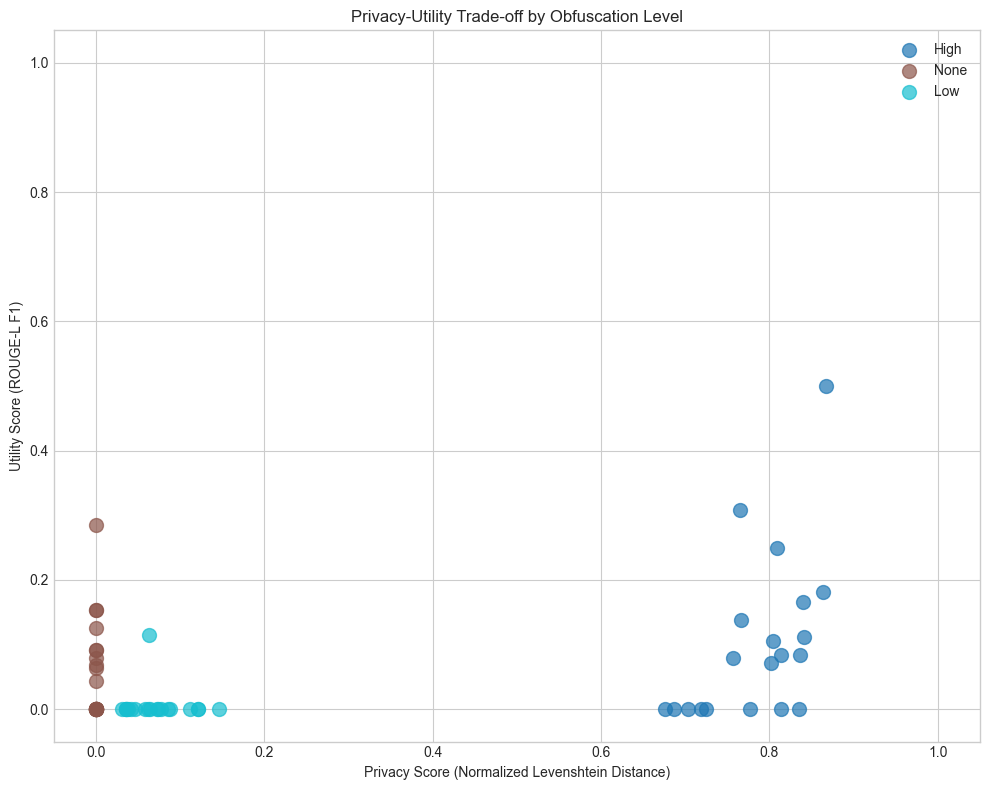

In [8]:
all_privacy = original_privacy + low_privacy + high_privacy
all_utility = original_utility + low_utility + high_utility
all_labels = ['None'] * 20 + ['Low'] * 20 + ['High'] * 20

plotter = PrivacyUtilityPlotter(figure_size=(10, 8))
fig = plotter.create_scatter_plot(
    all_privacy,
    all_utility,
    labels=all_labels,
    title="Privacy-Utility Trade-off by Obfuscation Level",
    xlabel="Privacy Score (Normalized Levenshtein Distance)",
    ylabel="Utility Score (ROUGE-L F1)"
)
plt.show()

## 9. Analysis

Brief analysis of the observed privacy-utility trade-off.

In [9]:
print("="*60)
print("PRIVACY-UTILITY TRADE-OFF ANALYSIS")
print("="*60)
print("\nSummary Statistics:")
print("-"*40)
print(f"{'Level':<10} {'Privacy Mean':>15} {'Utility Mean':>15}")
print("-"*40)
print(f"{'None':<10} {np.mean(original_privacy):>15.4f} {np.mean(original_utility):>15.4f}")
print(f"{'Low':<10} {np.mean(low_privacy):>15.4f} {np.mean(low_utility):>15.4f}")
print(f"{'High':<10} {np.mean(high_privacy):>15.4f} {np.mean(high_utility):>15.4f}")
print("-"*40)

print("\nObservations:")
print("1. No obfuscation (None) has privacy=0 since prompts are unchanged.")
print("2. Low obfuscation provides moderate privacy with variable renaming.")
print("3. High obfuscation maximizes privacy but may reduce utility.")
print("4. The trade-off shows that increased privacy often comes at the cost")
print("   of reduced utility, as the model receives less semantic information.")

privacy_increase = np.mean(high_privacy) - np.mean(original_privacy)
utility_change = np.mean(high_utility) - np.mean(original_utility)
print(f"\nHigh vs None obfuscation:")
print(f"  Privacy increase: +{privacy_increase:.4f}")
print(f"  Utility change: {utility_change:+.4f}")

PRIVACY-UTILITY TRADE-OFF ANALYSIS

Summary Statistics:
----------------------------------------
Level         Privacy Mean    Utility Mean
----------------------------------------
None                0.0000          0.0579
Low                 0.0704          0.0057
High                0.7850          0.1039
----------------------------------------

Observations:
1. No obfuscation (None) has privacy=0 since prompts are unchanged.
2. Low obfuscation provides moderate privacy with variable renaming.
3. High obfuscation maximizes privacy but may reduce utility.
4. The trade-off shows that increased privacy often comes at the cost
   of reduced utility, as the model receives less semantic information.

High vs None obfuscation:
  Privacy increase: +0.7850
  Utility change: +0.0461


## 10. Save Results

In [10]:
import json

results = {
    'none': {'privacy_scores': original_privacy, 'utility_scores': original_utility},
    'low': {'privacy_scores': low_privacy, 'utility_scores': low_utility},
    'high': {'privacy_scores': high_privacy, 'utility_scores': high_utility}
}

with open('results.json', 'w') as f:
    json.dump(results, f, indent=2)

plotter.save_figure(fig, 'privacy_utility_scatter.png')
print("Results saved to results.json and privacy_utility_scatter.png")

Results saved to results.json and privacy_utility_scatter.png
